In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re  
import warnings
import os 
warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
plt.style.use('seaborn')

In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets 
import torchvision.transforms as tt

In [3]:
df = pd.read_csv('archive (10)/FakeNewsNet.csv')
df.head()

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


In [4]:
df = df.drop(columns = 'news_url')
df.head()

,title,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,www.zerchoo.com,38,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23196 entries, 0 to 23195
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          23196 non-null  object
 1   source_domain  22866 non-null  object
 2   tweet_num      23196 non-null  int64 
 3   real           23196 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 725.0+ KB


In [6]:
df.fillna('missing' , inplace = True)

In [7]:
most_active_domains = df[~(df['source_domain']=='missing')]['source_domain'].value_counts()[:20]
most_active_domains

people.com                   1786
www.dailymail.co.uk           964
en.wikipedia.org              741
www.usmagazine.com            709
www.etonline.com              666
www.longroom.com              549
hollywoodlife.com             524
www.usatoday.com              332
www.hollywoodreporter.com     330
variety.com                   304
ew.com                        255
www.elle.com                  205
web.archive.org               204
www.billboard.com             197
www.today.com                 195
www.msn.com                   194
radaronline.com               192
time.com                      182
www.thewrap.com               177
deadline.com                  159
Name: source_domain, dtype: int64

In [8]:
avg_of_real_news = []
for i in most_active_domains.index:
    x = df[df['source_domain'] == i]['real'].mean()
    avg_of_real_news.append(x)
avg_of_real_news

[0.8790593505039194,
 0.7987551867219918,
 0.8340080971659919,
 0.7926657263751763,
 0.8783783783783784,
 1.0,
 0.12213740458015267,
 0.9036144578313253,
 0.9030303030303031,
 0.8519736842105263,
 0.8392156862745098,
 0.751219512195122,
 0.6617647058823529,
 0.8324873096446701,
 0.9230769230769231,
 0.6185567010309279,
 0.09375,
 0.8516483516483516,
 0.9152542372881356,
 0.9056603773584906]

Text(0.5, 1.0, 'Avg Of Real News')

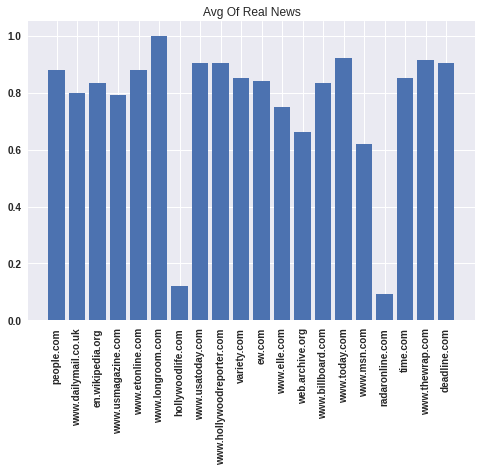

In [37]:
plt.bar(most_active_domains.index , avg_of_real_news)
plt.xticks(rotation = 90)
plt.title('Avg Of Real News')

**we can infer from above graph that source domain could be make a difference when we need to predict the target variable**

In [9]:
df[df['source_domain']=='missing']['real'].mean()

0.21212121212121213

**From The Above Cell , we know that if we don't have a source_domain we have a high probability that is a fake news**

In [10]:
df[df['source_domain'].str.contains('WWW')]

,title,source_domain,tweet_num,real


In [11]:
def feature_engineering(x):
    hold = re.search(r'\w*\.?[a-zA-Z0-9-_]+\.(.+)' , x)
    if hold:
        return hold.group(1)
    return "No Domain"


In [12]:
  # Test The Function
feature_engineering('www.dailymail.co.uk') , feature_engineering('dailymail.com'), feature_engineering('missing')

('co.uk', 'com', 'No Domain')

In [13]:
df['domain_suffix'] = df['source_domain'].apply(feature_engineering)
df.head()

,title,source_domain,tweet_num,real,domain_suffix
0,Kandi Burruss Explodes Over Rape Accusation on...,toofab.com,42,1,com
1,People's Choice Awards 2018: The best red carp...,www.today.com,0,1,com
2,Sophia Bush Sends Sweet Birthday Message to 'O...,www.etonline.com,63,1,com
3,Colombian singer Maluma sparks rumours of inap...,www.dailymail.co.uk,20,1,co.uk
4,Gossip Girl 10 Years Later: How Upper East Sid...,www.zerchoo.com,38,1,com


In [14]:
top_suffix = df['domain_suffix'].value_counts()[:20]
top_suffix

com          18690
co.uk         1552
org           1289
No Domain      330
com.au         330
uk             142
net            108
gov             87
news            72
ca              69
co              61
ie              55
tv              36
co.za           33
co.in           28
us              26
co.nz           20
pk              19
one             15
msn.com         13
Name: domain_suffix, dtype: int64

In [15]:
avg_real_news = []
for i in top_suffix.index:
    avg_real_news.append(df[df['domain_suffix']==i]['real'].mean())
avg_real_news

[0.770733012306046,
 0.7184278350515464,
 0.7897595034910784,
 0.21212121212121213,
 0.3424242424242424,
 0.6971830985915493,
 0.7129629629629629,
 0.9195402298850575,
 0.8333333333333334,
 0.8405797101449275,
 0.7868852459016393,
 0.6,
 0.7222222222222222,
 0.8484848484848485,
 0.03571428571428571,
 0.7307692307692307,
 0.65,
 0.631578947368421,
 0.9333333333333333,
 1.0]

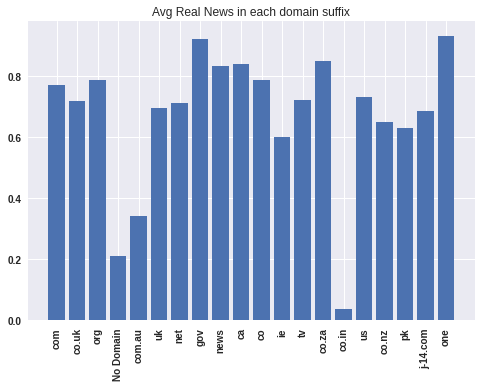

In [95]:
plt.bar(top_suffix.index , avg_real_news)
plt.xticks(rotation = 90)
plt.title('Avg Real News in each domain suffix');

In [16]:
import spacy 
nlp = spacy.load("en_core_web_lg")

In [17]:
def text_preprocessing(x):
    doc = nlp(x)
    
    filterd_token = []
    
    for token in doc:
        if not (token.is_punct or token.is_stop):
            filterd_token.append(str(token.lemma_))
    return " ".join(filterd_token)

In [18]:
df.loc[1]['title']

"People's Choice Awards 2018: The best red carpet looks"

In [19]:
# Test The Function
text_preprocessing(df.loc[1]['title'])

'People Choice Awards 2018 good red carpet look'

In [20]:
df['text'] = df['title'].apply(text_preprocessing)
df.head()

,title,source_domain,tweet_num,real,domain_suffix,text
0,Kandi Burruss Explodes Over Rape Accusation on...,toofab.com,42,1,com,Kandi Burruss explode Rape accusation real Hou...
1,People's Choice Awards 2018: The best red carp...,www.today.com,0,1,com,People Choice Awards 2018 good red carpet look
2,Sophia Bush Sends Sweet Birthday Message to 'O...,www.etonline.com,63,1,com,Sophia Bush send sweet Birthday message Tree H...
3,Colombian singer Maluma sparks rumours of inap...,www.dailymail.co.uk,20,1,co.uk,colombian singer Maluma spark rumour inappropr...
4,Gossip Girl 10 Years Later: How Upper East Sid...,www.zerchoo.com,38,1,com,Gossip Girl 10 year later Upper East sider sho...


In [21]:
df = df.drop(columns ='title')

In [22]:
df.head()

,source_domain,tweet_num,real,domain_suffix,text
0,toofab.com,42,1,com,Kandi Burruss explode Rape accusation real Hou...
1,www.today.com,0,1,com,People Choice Awards 2018 good red carpet look
2,www.etonline.com,63,1,com,Sophia Bush send sweet Birthday message Tree H...
3,www.dailymail.co.uk,20,1,co.uk,colombian singer Maluma spark rumour inappropr...
4,www.zerchoo.com,38,1,com,Gossip Girl 10 year later Upper East sider sho...


In [23]:
df.head()

,source_domain,tweet_num,real,domain_suffix,text
0,toofab.com,42,1,com,Kandi Burruss explode Rape accusation real Hou...
1,www.today.com,0,1,com,People Choice Awards 2018 good red carpet look
2,www.etonline.com,63,1,com,Sophia Bush send sweet Birthday message Tree H...
3,www.dailymail.co.uk,20,1,co.uk,colombian singer Maluma spark rumour inappropr...
4,www.zerchoo.com,38,1,com,Gossip Girl 10 year later Upper East sider sho...


In [24]:
df['vector'] = df['text'].apply(lambda x : nlp(x).vector)

In [25]:
df['domain_vector'] = df['source_domain'].apply(lambda x : nlp(x).vector)

In [26]:
df['suffix_vector'] = df['domain_suffix'].apply(lambda x : nlp(x).vector)

In [27]:
df.head()

,source_domain,tweet_num,real,domain_suffix,text,vector,domain_vector,suffix_vector
0,toofab.com,42,1,com,Kandi Burruss explode Rape accusation real Hou...,"[-0.4944977, 0.55524904, 0.029347325, 0.531715...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.3196, -1.042, 3.3605, -1.3344, -4.5178, -0...."
1,www.today.com,0,1,com,People Choice Awards 2018 good red carpet look,"[-0.2919963, -0.80936384, -2.3515975, 1.375661...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.3196, -1.042, 3.3605, -1.3344, -4.5178, -0...."
2,www.etonline.com,63,1,com,Sophia Bush send sweet Birthday message Tree H...,"[-1.332612, -1.9557451, 0.05786579, -0.4090297...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.3196, -1.042, 3.3605, -1.3344, -4.5178, -0...."
3,www.dailymail.co.uk,20,1,co.uk,colombian singer Maluma spark rumour inappropr...,"[0.26080623, 0.58870625, -0.83746624, -1.45354...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.7281, -1.542, 1.5109, -0.65479, -0.38351, -..."
4,www.zerchoo.com,38,1,com,Gossip Girl 10 year later Upper East sider sho...,"[-0.921845, -0.7150187, 1.1188186, -0.40771428...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.3196, -1.042, 3.3605, -1.3344, -4.5178, -0...."


**I will stop here, but i will give u some tips to continue after me:**<pre>
1 - you can use OneHotEncoder on domain suffix instead of word2vec or use both together , u need to try first to decide
2 - data are imbalance ,so u could do oversampling or increase class weight for zeros
3 - u need to normalize tweet_num first if u will uses model like KNN or any model use distance to solve the problem
4 - u can try another approach using TFIDF or Merge it with Word2Vec